In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
from util import spacy_get_sents, spacy_tokenize_text, nlp, get_entities

2023-05-13 04:37:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-13 04:37:03 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-05-13 04:37:03 INFO: Using device: cpu
2023-05-13 04:37:03 INFO: Loading: tokenize
2023-05-13 04:37:03 INFO: Loading: pos
2023-05-13 04:37:04 INFO: Done loading processors!


In [4]:
df = pd.read_csv("df_with_texts.csv", index_col=0)

In [5]:
df = df.replace(r'\n',' ', regex=True)
df

,Person,Subcategory,Category,Text
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...
...,...,...,...,...
7053,Uhwudong,Korean writers,Writers,"Eowudong or Uhwudong (어우동, 於宇同; 1440 - 18 Octo..."
5383,Óttar M. Norðfjörð,Icelandic writers,Writers,Óttar Martin Norðfjörð (born 1980) is an Icela...
4093,Claude Phillips,English writers,Writers,Sir Claude Phillips (29 January 1846 – 9 Augus...
7477,Francis Moto,Malawian writers,Writers,Professor Francis P. B. Moto (born 1952) is a ...


# **Count sentences of each category**

In [6]:
astronauts = df.loc[df['Category'] == 'Astronauts'] #subframe of astronauts 
astronauts.head()

,Person,Subcategory,Category,Text
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...


In [7]:
writers = df.loc[df['Category'] == 'Writers'] #subframe of writers
writers.head()

,Person,Subcategory,Category,Text
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr..."
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i..."
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu..."
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...


In [8]:
writers["Sentences"] = writers['Text'].apply(spacy_get_sents) # Apply the function to the text colum and create a new column with the output
writers['Num_sentences'] = writers['Sentences'].apply(lambda x: len(x)) # Now we get the number of sentences of each article 

In [9]:
writers.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr...","[Sagit Agish (1904–1973) was a Bashkir poet, w...",13
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...,[(Prop) Preller Geldenhuys was a pilot in the ...,10
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i...","[Marcelo Gustavo Kohen (born August 11, 1957) ...",40
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu...","[Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: F...",168
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...,[James Gregory (7 November 1941 – 2003) was th...,29


In [10]:
#We do the same with astronauts...

astronauts['Sentences'] = astronauts['Text'].apply(spacy_get_sents)
astronauts['Num_sentences'] = astronauts['Sentences'].apply(lambda x: len(x))

In [11]:
len(astronauts["Sentences"].iloc[0])

41

In [12]:
def calculate_stats(data):
    """
    This function takes a list of numbers as input, and returns a formatted string
    containing the minimum, maximum, and average values.
    """
    minimum = min(data)
    maximum = max(data)
    average = sum(data) / len(data)

    stats_str = f"This is the average: {average} \nThis is the maximum: {maximum} \nThis is the minimum: {minimum}"

    return stats_str

Stats for astronauts article length (in sentences):

In [13]:
print(calculate_stats(astronauts['Num_sentences']))

This is the average: 43.98 
This is the maximum: 324 
This is the minimum: 2


Stats for writers article length (in sentences):

In [14]:
print(calculate_stats(writers['Num_sentences']))

This is the average: 30.695 
This is the maximum: 267 
This is the minimum: 2


# Visualization

### Histograms

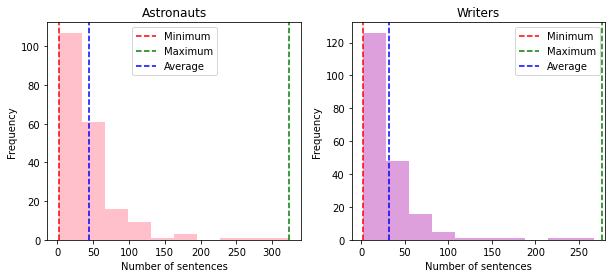

In [15]:
# Create a figure with two subplots, side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first histogram on the left subplot
axs[0].hist(astronauts['Num_sentences'], bins=10,color='pink')
axs[0].axvline(x=2, color='r', linestyle='--', label='Minimum')
axs[0].axvline(x=324, color='g', linestyle='--', label='Maximum')
axs[0].axvline(x=44.25, color='b', linestyle='--', label='Average')
axs[0].set_title('Astronauts')

# Plot the second histogram on the right subplot
axs[1].hist(writers['Num_sentences'], bins=10, color = "plum")
axs[1].axvline(x=2, color='r', linestyle='--', label='Minimum')
axs[1].axvline(x=277, color='g', linestyle='--', label='Maximum')
axs[1].axvline(x=31.37, color='b', linestyle='--', label='Average')
axs[1].set_title('Writers')


# Set the x-axis and y-axis labels for both subplots
for ax in axs:
    ax.set_xlabel('Number of sentences')
    ax.set_ylabel('Frequency')
    ax.legend()

# Show the figure
plt.show()


### Boxplots

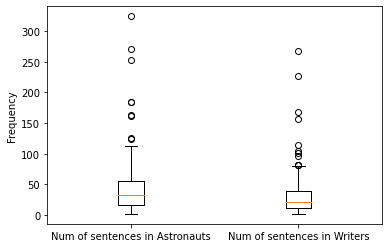

In [16]:
# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the boxplots side-by-side using the "positions" parameter
ax.boxplot([astronauts['Num_sentences'], writers['Num_sentences']], positions=[1, 2])

# Set the labels and limits
ax.set_xticklabels(['Num of sentences in Astronauts', 'Num of sentences in Writers'])
ax.set_xlim(0.5, 2.5)
ax.set_ylabel('Frequency')

# Show the figure
plt.show()

## **Tokenization**

In [17]:
#We apply the the function tokenize_sentence to astronauts and create a new colum with the result
astronauts["tokenized_sentences"] = astronauts["Sentences"].apply(lambda x: 
                                                                  list(
                                                                      map(
                                                                          lambda y: spacy_tokenize_text(y, to_lowercase=True),
                                                                          x
                                                                          )
                                                                      )
                                                                 )
astronauts.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an...","[Jeanette Jo Epps (born November 3, 1970) is a...",41,"[[jeanette, jo, epps, born, november, 3, 1970,..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...,[Sergei Vasilyevich Avdeyev (Сергей Васильевич...,28,"[[sergei, vasilyevich, avdeyev, сергей, василь..."
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...,[Matthias Josef Maurer (born 18 March 1970) is...,31,"[[matthias, josef, maurer, born, 18, march, 19..."
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...,[Andriyan Grigoryevich Nikolayev (Chuvash and ...,52,"[[andriyan, grigoryevich, nikolayev, chuvash, ..."
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...,[Gennady Mikhailovich Manakov (Russian: Геннад...,7,"[[gennady, mikhailovich, manakov, russian, ген..."


In [18]:
astronauts.to_csv('output_astronauts.csv', index=False)

In [19]:
#We apply the the function tokenize_sentence to writers and create a new colum with the result

writers["tokenized_sentences"] = writers["Sentences"].apply(lambda x: 
                                                                  list(
                                                                      map(
                                                                          lambda y: spacy_tokenize_text(y, to_lowercase=True),
                                                                          x
                                                                          )
                                                                      )
                                                      )
writers.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
10112,Sagit Agish,Soviet writers,Writers,"Sagit Agish (1904–1973) was a Bashkir poet, wr...","[Sagit Agish (1904–1973) was a Bashkir poet, w...",13,"[[sagit, agish, 1904–1973, bashkir, poet, writ..."
9851,Preller Geldenhuys,South African writers,Writers,(Prop) Preller Geldenhuys was a pilot in the R...,[(Prop) Preller Geldenhuys was a pilot in the ...,10,"[[prop, preller, geldenhuys, pilot, rhodesian,..."
1005,Marcelo Kohen,Argentine writers,Writers,"Marcelo Gustavo Kohen (born August 11, 1957) i...","[Marcelo Gustavo Kohen (born August 11, 1957) ...",40,"[[marcelo, gustavo, kohen, born, august, 11, 1..."
6902,Masanobu Fukuoka,Japanese writers,Writers,"Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: Fu...","[Masanobu Fukuoka (Japanese: 福岡 正信, Hepburn: F...",168,"[[masanobu, fukuoka, japanese, 福岡, 正信, hepburn..."
9791,James Gregory (prison officer),South African writers,Writers,James Gregory (7 November 1941 – 2003) was the...,[James Gregory (7 November 1941 – 2003) was th...,29,"[[james, gregory, 7, november, 1941, 2003, cen..."


In [20]:
writers.to_csv('output_writers.csv', index=False)

Now we count the number of tokens of each sentences and represent the output

In [21]:
#we count the tokens of each sentence

tokens_per_sentence_wr = writers["tokenized_sentences"].apply(lambda x: list(map(lambda y: len(y), x)))
tokens_per_sentence_as = astronauts["tokenized_sentences"].apply(lambda x: list(map(lambda y: len(y), x)))

In [22]:
#We count the total tokens of each row

total_wr= tokens_per_sentence_wr.apply(lambda x: sum(x))
total_as= tokens_per_sentence_as.apply(lambda x: sum(x))

The stats for token count per article for `Writers`:

In [23]:
#We get the min, max and avg
print(calculate_stats(total_wr))

This is the average: 354.4 
This is the maximum: 3818 
This is the minimum: 13


The stats for token count per article for `Astronauts`:

In [24]:
print(calculate_stats(total_as))

This is the average: 557.62 
This is the maximum: 4449 
This is the minimum: 29


# **Visualization**

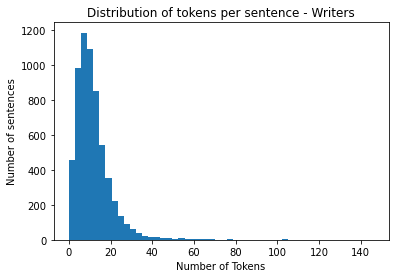

In [25]:
# Since tokens in our dataframe are in a list of list we need to flatten it first
tokens_per_sentence_wr_flat = np.concatenate(list(tokens_per_sentence_wr))

#Histogram of tokens per sentence - Writers
plt.hist(tokens_per_sentence_wr_flat, bins=50)


# Add labels and a title to the plot
plt.xlabel("Number of Tokens")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokens per sentence - Writers")

# Show the plot
plt.show()

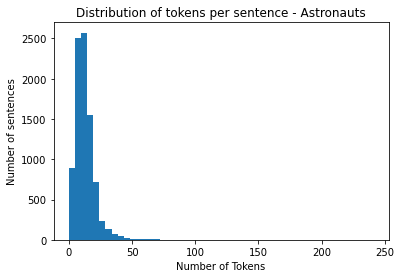

In [26]:
# Since tokens in our dataframe are in a list of list we need to flatten it first
tokens_per_sentence_as_flat = np.concatenate(list(tokens_per_sentence_as))

#Histogram of tokens per sentence - Astronauts
plt.hist(tokens_per_sentence_as_flat, bins=50)

# Add labels and a title to the plot
plt.xlabel("Number of Tokens")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokens per sentence - Astronauts")

# Show the plot
plt.show()

Histograms of tokens per category per article:

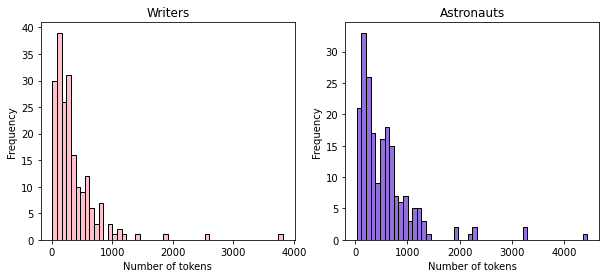

In [27]:
# Create a figure with two subplots, side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first histogram on the left subplot
axs[0].hist(total_wr, bins=50,color='pink',edgecolor='black')
axs[0].set_title('Writers')

# Plot the second histogram on the right subplot
axs[1].hist(total_as, bins=50, color = "mediumpurple",edgecolor='black')
axs[1].set_title('Astronauts')


# Set the x-axis and y-axis labels for both subplots
for ax in axs:
    ax.set_xlabel('Number of tokens')
    ax.set_ylabel('Frequency')

# Show the figure
plt.show()

# **Name entity recognition**

In [28]:
#We apply it to the column text of the dataset

entities_as = astronauts["Text"].apply(get_entities)
entities_wr = writers["Text"].apply(get_entities)

In [29]:
from spacy import displacy

#we can dispay the entities to see them more clearly. To show an example we display the entities of one text

displacy.render(nlp(astronauts["Text"].iloc[12]), style='ent', jupyter=True) 

In [30]:
#We make a list of the total entities. Entities_as and entities_wr are arrays of Pandas Series of arrays, 
# so we'll use numpy.concatenate to flatten it to a 1-dimensional array.

list_entities_as = np.concatenate(list(entities_as))
list_entities_wr = np.concatenate(list(entities_wr))

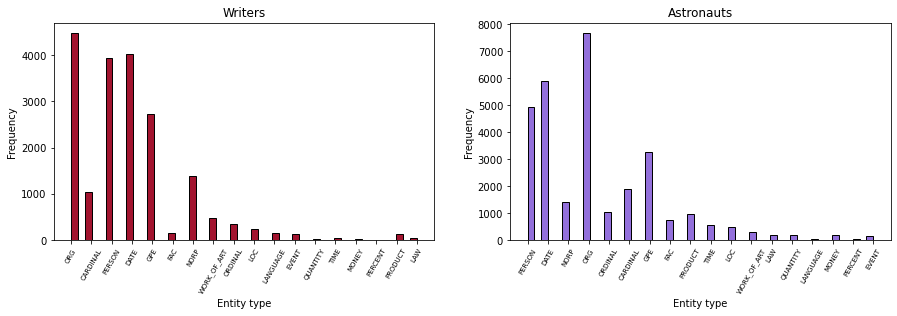

In [31]:
#Finally we display a histogram of the number of entities recognized in each category

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plot the first histogram on the left subplot
axs[0].hist(list_entities_wr, bins=50,color="#A2142F",edgecolor='black')
axs[0].set_title('Writers')

# Plot the second histogram on the right subplot
axs[1].hist(list_entities_as, bins=50, color = "mediumpurple",edgecolor='black')
axs[1].set_title('Astronauts')



# Set the x-axis and y-axis labels and parameters for both subplots
for ax in axs:
    ax.set_xlabel('Entity type')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', labelsize=7, rotation=60)

# Show the figure
plt.show()

# Word frequency

In [32]:
# Combine the already tokenized data
df_tokenized = pd.concat([astronauts, writers])

In [33]:
df_tokenized.head()

,Person,Subcategory,Category,Text,Sentences,Num_sentences,tokenized_sentences
104,Jeanette Epps,American astronauts,Astronauts,"Jeanette Jo Epps (born November 3, 1970) is an...","[Jeanette Jo Epps (born November 3, 1970) is a...",41,"[[jeanette, jo, epps, born, november, 3, 1970,..."
288,Sergey Avdeev,Russian cosmonauts,Astronauts,Sergei Vasilyevich Avdeyev (Сергей Васильевич ...,[Sergei Vasilyevich Avdeyev (Сергей Васильевич...,28,"[[sergei, vasilyevich, avdeyev, сергей, василь..."
198,Matthias Maurer,German astronauts,Astronauts,Matthias Josef Maurer (born 18 March 1970) is ...,[Matthias Josef Maurer (born 18 March 1970) is...,31,"[[matthias, josef, maurer, born, 18, march, 19..."
365,Andriyan Nikolayev,Soviet cosmonauts,Astronauts,Andriyan Grigoryevich Nikolayev (Chuvash and R...,[Andriyan Grigoryevich Nikolayev (Chuvash and ...,52,"[[andriyan, grigoryevich, nikolayev, chuvash, ..."
412,Gennady Manakov,Soviet cosmonauts,Astronauts,Gennady Mikhailovich Manakov (Russian: Геннади...,[Gennady Mikhailovich Manakov (Russian: Геннад...,7,"[[gennady, mikhailovich, manakov, russian, ген..."


In [34]:
# Get the unique categories and subcategories of data

cat = df_tokenized.Category.unique()
sub_cat = df.Subcategory.unique()
len(cat), len(sub_cat)

(2, 115)

In [35]:
# We join all texts by categories
cat_txt = {}
for c in cat:
    cat_txt[c] = df[df['Category']==c].Text.str.cat(sep=' ').lower()

len(cat_txt)

2

In [54]:
pip show numpy

Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Users/egoliakova/opt/anaconda3/lib/python3.8/site-packages
Requires: 
Required-by: yellowbrick, wordcloud, tslearn, transformers, tifffile, thinc, tensorflow, tensorboard, tables, statsmodels, stanza, spacy, spacy-pkuseg, simalign, seaborn, scipy, scikit-learn, scikit-image, sacrebleu, PyWavelets, pyarrow, patsy, pandas, opt-einsum, numexpr, numba, mkl-random, mkl-fft, matplotlib, Keras-Preprocessing, imageio, h5py, gensim, faiss, fairseq, evaluate, datasets, Bottleneck, bootstrap-stat, bokeh, blis, bkcharts, astropy
Note: you may need to restart the kernel to use updated packages.


Numpy version should be `1.23.5`

In [56]:
pip install numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.


In [36]:
# We join all tokens by categories
cat_token = {}
for c in cat:
    # Flattens the data of list of lists in 1-d array
    cat_token[c] = np.concatenate(
        np.concatenate(list(df_tokenized[df_tokenized.Category == c].tokenized_sentences))
    )
len(cat_token)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2

In [37]:
# We join all tokens by subcategories
sub_cat_token = {}
for c in sub_cat:
    # Flattens the data of list of lists in 1-d array
    sub_cat_token[c] = np.concatenate(
        np.concatenate(list(df_tokenized[df_tokenized.Subcategory == c].tokenized_sentences))
    )
len(sub_cat_token)

115

## 50 most frequents words

In [38]:
# we find the 50 most frequents words by categories 
cat_freq_list = []

for cat, v in cat_token.items(): # for each category
    freq_list = list(zip(
                            np.unique(v, return_counts=True)[0],
                            np.unique(v, return_counts=True)[1])
        ) # Get the words and counts in the following format [(word1, 1), (word2, 1)... ]
    

    # Sort by number of occurences and take the 50 first words
    freq_50 =  sorted(freq_list, key=lambda x: x[1], reverse=True)[:50] 
    
    for w, c in freq_50:
        cat_freq_list.append(
            {
                'Word': w,
                'Count': c,
                'Category': cat
            }
        )
    

cat_freq_df = pd.DataFrame(cat_freq_list)
cat_freq_df

,Word,Count,Category
0,space,2382,Astronauts
1,mission,845,Astronauts
2,flight,744,Astronauts
3,nasa,739,Astronauts
4,astronaut,720,Astronauts
...,...,...,...
95,language,105,Writers
96,history,103,Writers
97,college,99,Writers
98,2011,97,Writers


In [39]:
cat_freq_df.to_csv('top50_freq_word_by_cat.csv')

In [40]:
subcat_freq_list = []

for subcat, v in sub_cat_token.items(): # for each category
    freq_list = list(zip(
                            np.unique(v, return_counts=True)[0],
                            np.unique(v, return_counts=True)[1])
        ) # Get the words and counts in the following format [(word1, 1), (word2, 1)... ]
    

    # Sort by number of occurences and take the 50 first words
    freq_50 =  sorted(freq_list, key=lambda x: x[1], reverse=True)[:50] 
    
    for w, c in freq_50:
        subcat_freq_list.append(
            {
                'Word': w,
                'Count': c,
                'Subcategory': subcat
            }
        )
    

subcat_freq_df = pd.DataFrame(subcat_freq_list)
subcat_freq_df

,Word,Count,Subcategory
0,space,794,American astronauts
1,nasa,492,American astronauts
2,mission,352,American astronauts
3,astronaut,345,American astronauts
4,flight,273,American astronauts
...,...,...,...
5661,series,2,Malaysian writers
5662,shakespeare,2,Malaysian writers
5663,skills,2,Malaysian writers
5664,spelling,2,Malaysian writers


In [41]:
subcat_freq_df.to_csv('top50_freq_word_by_subcat.csv')

## Wordclouds

This task use the library WordCloud. This library do its own preprocessing so we don't exactly find the same words. We can still see that most word are the same in both the wordclouds and our own list. They seems to have less useless words like 'also', 'from', 'with' ot 'that' whithout loosing small important words like 'ST', 'ISS' or 'one'

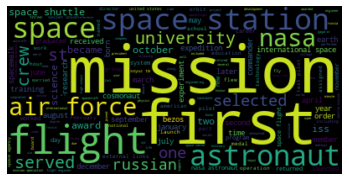

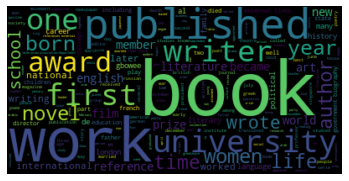

In [42]:
for k,v in cat_txt.items(): # for each categories 
    wordcloud = WordCloud().generate(v) # we generate the worldcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show() # we show it
    wordcloud.to_file("Viz/wc_by_cat/wc_"+k+".jpg") # and we save it

In [43]:
[(w, c) for w, c in wordcloud.words_.items()]

[('book', 1.0),
 ('work', 0.9),
 ('published', 0.7848484848484848),
 ('university', 0.7242424242424242),
 ('writer', 0.6909090909090909),
 ('first', 0.6909090909090909),
 ('one', 0.6636363636363637),
 ('award', 0.6060606060606061),
 ('year', 0.603030303030303),
 ('born', 0.6),
 ('women', 0.5515151515151515),
 ('novel', 0.5363636363636364),
 ('time', 0.4696969696969697),
 ('author', 0.46060606060606063),
 ('life', 0.45151515151515154),
 ('wrote', 0.44545454545454544),
 ('school', 0.41818181818181815),
 ('literature', 0.4),
 ('member', 0.39090909090909093),
 ('english', 0.38484848484848483),
 ('new', 0.38181818181818183),
 ('art', 0.38181818181818183),
 ('film', 0.3787878787878788),
 ('prize', 0.37272727272727274),
 ('reference', 0.3696969696969697),
 ('became', 0.36363636363636365),
 ('world', 0.36363636363636365),
 ('international', 0.3575757575757576),
 ('writing', 0.34545454545454546),
 ('later', 0.3424242424242424),
 ('national', 0.3393939393939394),
 ('worked', 0.33636363636363636)

In [44]:
cat_freq_df[cat_freq_df.Category == 'Writers'].Word

50       university
51        published
52             book
53             life
54             born
55               de
56              new
57            women
58             film
59       references
60            works
61           writer
62            books
63    international
64            novel
65           school
66            world
67            years
68            award
69            wrote
70               al
71       literature
72            prize
73          english
74             isbn
75         national
76             work
77         literary
78           author
79            later
80           career
81           member
82           gbowee
83             time
84             year
85         children
86            peace
87              war
88            early
89           worked
90        political
91          writing
92           london
93           series
94           family
95         language
96          history
97          college
98             2011
99        education


## **TRAINING CLASSIFIERS**

To access the most frequent words use:
- For writers: `cat_freq_df[cat_freq_df.Category == 'Writers'].Word`
- For astronauts: `cat_freq_df[cat_freq_df.Category == 'Astronaut'].Word`

In [45]:
from sklearn.utils import shuffle
#Shuffle the data
df_tokenized = shuffle(df_tokenized)

In [46]:
from sklearn.preprocessing import LabelEncoder

labels_encoder = LabelEncoder()
df_tokenized['labels_encoded'] = labels_encoder.fit_transform(df_tokenized['Category'])

In [47]:
X = df_tokenized.tokenized_sentences.apply(lambda x: np.concatenate(x))
# Join the tokenized sentences into strings
X = [' '.join(tokens) for tokens in X]
Y = df_tokenized['labels_encoded']
Y.shape

(400,)

In [48]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                    test_size=0.30, random_state=0)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
# Using TFIDF vectorizer with pre-tokenized text
tfidf_vectorizer = TfidfVectorizer(max_features=400,
                                   use_idf=True,
                                   stop_words='english',
                                   ngram_range=(1, 2))

# Fit the vectorizer to train and test data
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train_tf.shape)
print('Test:', X_test_tf.shape)
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Train: (280, 400)
Test: (120, 400)
Vocabulary size: 400


In [51]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score

# Create a Perceptron object
clf = Perceptron(max_iter=5, tol=None, random_state=0)

# Train the model on the training data
clf.fit(X_train_tf, Y_train)

# Test the model on the test data
Y_pred = clf.predict( X_test_tf )

# Print out the expected values and the predictions
print( '\nExpected Values:',  list(Y_test) )
print( '\nPredictions:',  Y_pred )

# Print accuracy
print( "Acc:", accuracy_score( Y_test, Y_pred) )


Expected Values: [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]

Predictions: [0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0
 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0
 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0
 1 0 0 0 0 1 1 1 0]
Acc: 0.975


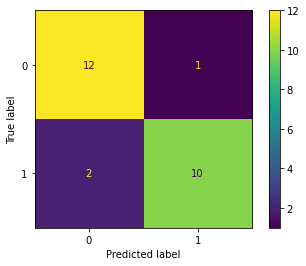

In [52]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()